In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
train_data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DIPLOMADO/2004airquality.csv') #Se usó la sección de datos del 2004 para entrenamiento

train_data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,10/03/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,10/03/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,10/03/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,10/03/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [4]:
test_data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DIPLOMADO/2005airquality.csv') #Se usó la sección de datos del 2005 para la prueba

test_data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,1/1/2005,0:00:00,-200.0,1046,-200,4.2,724,-200,848,-200,898,1201,8.2,40.1,0.4375
1,1/1/2005,1:00:00,1.6,1274,-200,8.8,930,215,648,106,1024,1617,5.3,50.7,0.4564
2,1/1/2005,2:00:00,2.5,1173,-200,7.5,878,300,738,129,1002,1355,5.9,50.0,0.4689
3,1/1/2005,3:00:00,2.7,1162,-200,7.6,881,-200,748,-200,1001,1296,4.9,53.9,0.4693
4,1/1/2005,4:00:00,1.9,1054,-200,5.6,791,253,830,126,966,1131,4.3,55.3,0.4650


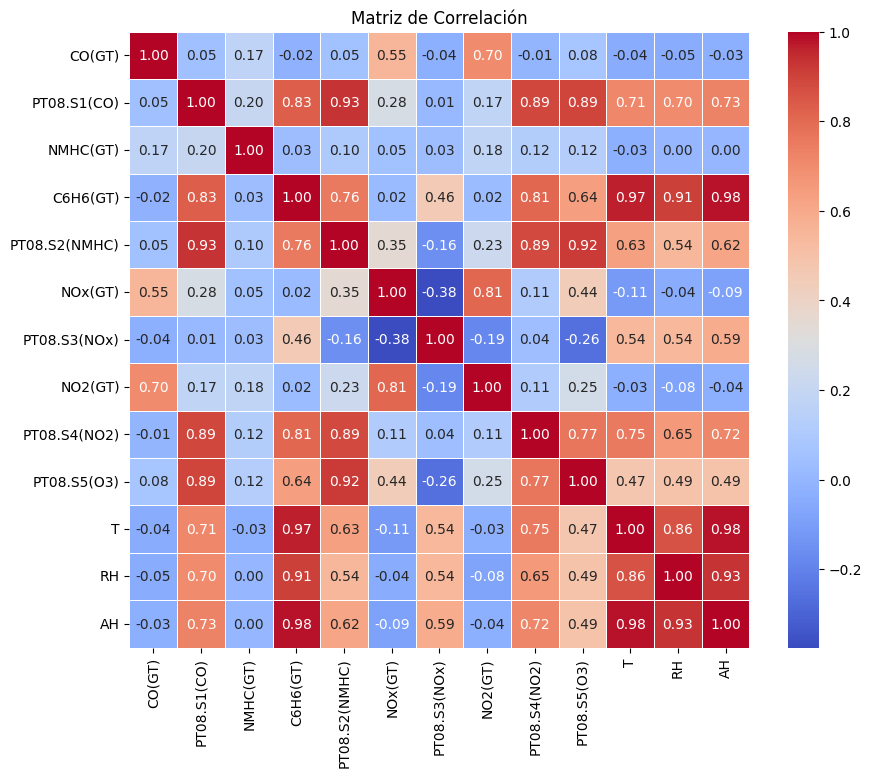

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_data = train_data.select_dtypes(include=['number'])
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

A partir de la matriz de correlación es posible notar que hay una relación alta entre la concentración de benceno C6H6(GT), la humedad relativa (RH), la humedad absoluta (AH) y la temperatura (T). Así que se tomarán en cuenta estas variables para predecir la concentración de benceno en el aire.

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [7]:
variables = ['C6H6(GT)', 'T', 'RH', 'AH'] #Se seleccionan solo las que utilizaremos
train_data = train_data[variables]
test_data = test_data[variables]

# Los valores invalidos pasan a ser el promedio de la columna
def clean_data(data):
    data.replace(['---', 'NaN', '', ' '], np.nan, inplace=True)
    imputer = SimpleImputer(strategy='mean')
    data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns, index=data.index)
    return data_imputed

train_data = clean_data(train_data)
test_data = clean_data(test_data)

<ipython-input-7-310e05991728>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.replace(['---', 'NaN', '', ' '], np.nan, inplace=True)
<ipython-input-7-310e05991728>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.replace(['---', 'NaN', '', ' '], np.nan, inplace=True)


In [8]:
# Se pasan los datos a un rango entre 0 y 1 para que sean más fáciles de entrenar
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)

In [9]:
# Crear secuencias para LSTM (de las 48 horas anteriores, los datos son los antes mencionados)
def create_dataset(dataset, look_back=48):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i+look_back])
        y.append(dataset[i+look_back, 0])  # C6H6(GT)
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(scaled_train, 48)
X_test, y_test = create_dataset(scaled_test, 48)

In [10]:
# Se ajusta el Modelo LSTM
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])), #Primera capa LSTM con 100 unidades
    Dropout(0.2), #Se apagan el 20% de la neuronas para que no haya sobreajuste
    LSTM(64), #Segunda capa con 64 unidades
    Dense(1) # Última capa densa con 1 unidad
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error') # Se usa el optimizador adam y como función de pérdida al error cuádratico medio

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 48, 100)        │        42,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,305 (329.32 KB)

 Trainable params: 84,305 (329.32 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Se hace el entrenamiento
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1) #Se utilizan solo 20 epocas para evitar sobreajuste y se reserva un conjunto de validación del 10%

Epoch 1/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - loss: 0.0481 - val_loss: 0.0123
Epoch 2/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - loss: 0.0058 - val_loss: 0.0108
Epoch 3/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - loss: 0.0051 - val_loss: 0.0099
Epoch 4/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - loss: 0.0040 - val_loss: 0.0101
Epoch 5/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - loss: 0.0043 - val_loss: 0.0079
Epoch 6/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - loss: 0.0038 - val_loss: 0.0072
Epoch 7/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - loss: 0.0034 - val_loss: 0.0066
Epoch 8/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - loss: 0.0032 - val_loss: 0.0056
Epoch 9/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - loss: 0.0028 - val_loss: 0.0049
Epoch 10/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - loss: 0.0035 - val_loss: 0.0047
Epoch 11/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - loss: 0.0027 - val_loss: 0.0049
Epoch 12/20
199/199 ━━━━━━━━━━

In [17]:
# Se aplica el modelo para predecir
predictions_scaled = model.predict(X_test)

# Desescalado de predicciones y valores reales
predictions = scaler.inverse_transform(np.concatenate(
    [predictions_scaled, np.zeros((len(predictions_scaled), scaled_test.shape[1] - 1))], axis=1))[:, 0]

y_test_real = scaler.inverse_transform(np.concatenate(
    [y_test.reshape(-1, 1), np.zeros((len(y_test), scaled_test.shape[1] - 1))], axis=1))[:, 0]

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


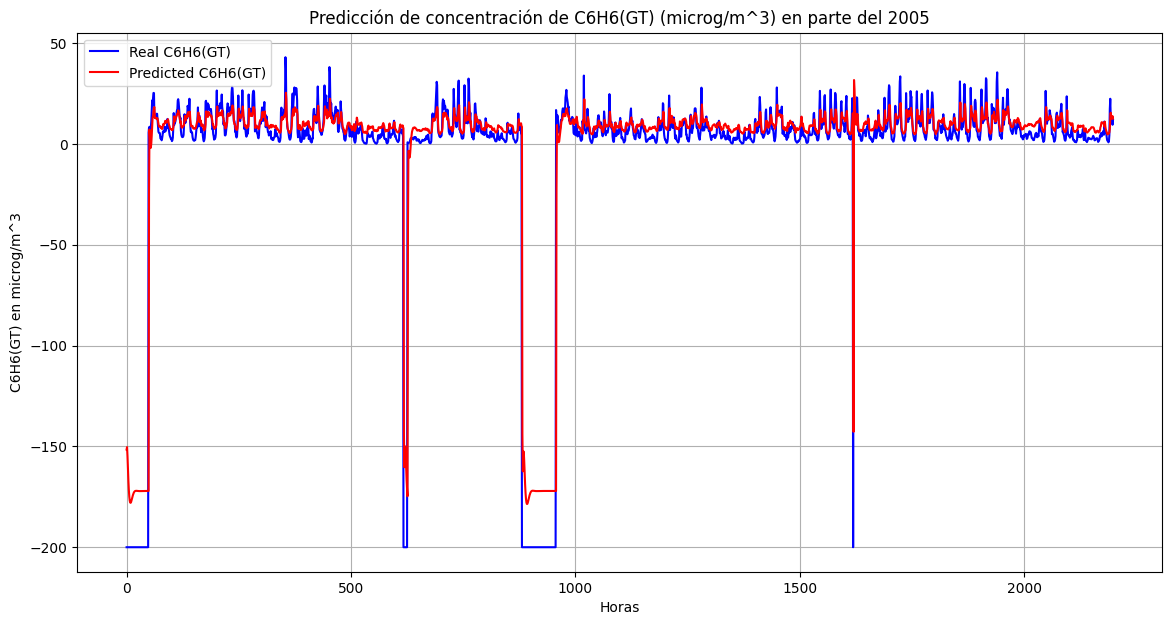

In [18]:
# Visualización de valores reales y predicciones
plt.figure(figsize=(14, 7))
plt.plot(y_test_real, label='Real C6H6(GT)', color='blue')
plt.plot(predictions, label='Predicted C6H6(GT)', color='red')
plt.title('Predicción de concentración de C6H6(GT) (microg/m^3) en parte del 2005')
plt.xlabel('Horas')
plt.ylabel('C6H6(GT) en microg/m^3')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
from sklearn.metrics import r2_score

# Calcular el R²
r2 = r2_score(y_test_real, predictions)
print(f'R² (R-squared) del modelo: {r2:.4f}') # El modelo explica el 92.4% de la variabilidad en la concentración de benceno en el conjunto de prueba


R² (R-squared) del modelo: 0.9242
